# Collaboration and Competition


### Introduction

Unity ML-agent library has a lot of simulation evnrionments to test intelligent agent models. 
This notebook solves one of the envrionnment which simulates a simple **Tennis** game.
The task is to move 2 rackets/players appropriately to keep balls within the tennis court.
Each time the ball crosses the tennis net towards the opponent side, the player gets a reward of +0.1, and if the ball hits the ground or moves outside of the court, the reward is -0.01. Therefore, a player should play well to pass a ball towards the other player to get a chance of high score.
The code uses a Deep Deterministic Policy Gradient model (DDPG) to learn a behavior to gain as many scores as possible. Although there are 2 agents, their situation is symmetric, so DDPG can be applied to both agents simultaneously.
All the code is self contained in a notebook for a potential modification of any logic. 
Each component is separated to its own cell, so it can be easily written to a separate file using "%writefile" if necessary

---


### 1. Environment
#### Requirements
- Linux based OS
- Python (dependency is listed in requirements.txt)
- [Linux Tennis environment](https://s3-us-west-1.amazonaws.com/udacity-drlnd/P3/Tennis/Tennis_Linux.zip)

The following code will import modules and packages required to train and evaluate a Actor/Critic models with DDPG algorithm

In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="./Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

#### The environment spec
- Number of agent: 2
- State space: 24 dimensional vector (for each agent)
- Action space: 2 numbers of range [-1, 1]
- Reward: +0.1 (If the ball crooses the net towards the opponent side), -0.01 (If the ball hits the ground or moves outside of the net)

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 2. Implementation

#### ActorModel
- **Description**
    - Standard fully-connected NN with a Batchnorm layer and ReLU activation. This model is used to model the deterministic policy, so it outputs 2-dimensional continous action vectors.
- **Architecture**
    - 3 Hidden layers (256, 256, 64 nodes)
    - 1 Output layer (2 nodes)
    - Each hidden layer uses ReLU and Batchnorm1d
    - Final output layer is a single linear layer with tanh activation to conform to the action value range
- **Discussion**
    - The initial hidden layer expanded the number of nodes for exploring rich feature space
    - ReLU and Batchnorm layer are used for stable training
    - Final output layer is combined with tanh to generate action of a correct range
    - 2 Hidden layers couldn't simulate a complex playing behavior, so it's increased to 3 layers
    - PyTorch 0.4 linear layer's initialization was too simple, so it's changed for better optimization. 
 
#### CriticModel
- **Description**
    - A fully-connected NN which combines a state and action to generate Q value for a given state, action pair.
- **Architecture**
    - 3 Hidden layers (512, 256, 128 nodes)
    - 1 Output layer (1 node)
    - Each hidden layer uses ReLU except for action feature embedding
    - Final output layer is a single linear layer without any activation function
- **Discussion**
    - To deal with different characteristics of state and action, they're embedded to the first hidden layer separately
        - The first hidden layer 512 nodes are divided according to the ratio of state and action dimensions (24 to 2)
    - The initial hidden layer expanded the number of nodes for exploring rich feature space
    - Architecture hyperparmeters are decided with experiments
    - Final output layer directly generates an action value
 

#### Buffer
- **Description**
    - Replay buffer used in a DDPG algorithm. It is a standard deque with a sampling function
- **Interface**
    - Initialization
        - sz: Replay buffer size
        - pf: Probability function for sampling
    - put(obj): Stored obj in a replay buffer
    - sample(n): Sample n objects from a replay buffer
    - update_pf(pf): Update the probability function pf
- **Discussion**
    - Each agent's experience is stored without any differentiation because agent's situation is symmetric
    - pf can be used for prioritized experience replay
    - It was used to explore the potential benefit of the skew in experience sampling, but was default to uniform sampling

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
class ActorModel(nn.Module):
    def __init__(self, nfs = [24, 256, 256, 64, 2]):# [24, 256, 128, 2]):
        super().__init__()
        self.nfs = nfs
        
        dr = nn.Dropout()
        layers = [nn.BatchNorm1d(self.nfs[0])]
        for nif, nof in zip(self.nfs[:-2], self.nfs[1:-1]):
            layers.append(nn.Linear(nif, nof))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(nof))
#             layers.append(dr)
        layers = layers[:-1]
    
        # Weight initialization
        for i in [1, 4, 7]:
            nn.init.kaiming_uniform_(layers[i].weight, a=math.sqrt(5))
        
        self.layers = nn.Sequential(*layers)
        self.olin = nn.Linear(self.nfs[-2], self.nfs[-1])
  
    
    def forward(self, x):
        f = self.layers(x)
        actions = F.tanh(self.olin(f))
        
        return actions

In [8]:
class CriticModel(nn.Module):
    def __init__(self, nfs = [512, 256, 128, 1], ns=24, na=2):
        super().__init__()
        self.nfs = nfs
        self.ns = ns
        self.na = na
        
        dr = nn.Dropout()
        
        num_state_fs = int(self.nfs[0] * self.ns /(self.ns+self.na))
        num_act_fs = self.nfs[0] - num_state_fs
        
        self.state_fs = nn.Sequential(
#             nn.BatchNorm1d(self.ns), 
            nn.Linear(self.ns, num_state_fs),
            nn.ReLU(),
            nn.BatchNorm1d(num_state_fs)
        )
        self.act_fs = nn.Sequential(
            nn.Linear(self.na, num_act_fs),
#             nn.ReLU(),
#             nn.BatchNorm1d(num_act_fs)
        )
        
        layers = []
        for nif, nof in zip(self.nfs[:-2], self.nfs[1:-1]):
            layers.append(nn.Linear(nif, nof))
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(nof))
#             layers.append(dr)
        layers = layers[:-1]
    
        # Weight initialization
        nn.init.kaiming_uniform_(self.state_fs[0].weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.act_fs[0].weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(layers[0].weight, a=math.sqrt(5))
        nn.init.kaiming_uniform_(layers[3].weight, a=math.sqrt(5))
        
        self.layers = nn.Sequential(*layers)
        self.olin = nn.Linear(self.nfs[-2], self.nfs[-1])
    
    def forward(self, x, a):
        xf = self.state_fs(x)
        af = self.act_fs(a)
        f = self.layers(torch.cat((xf, af), 1))
        values = self.olin(f)
        
        return values

In [9]:
class Buffer:
    def __init__(self, sz=50000, exp_sz=20, pf=lambda x: 1):
        self.buf = deque(maxlen=sz)
        self.px = deque(maxlen=sz)
        self.temp = []
        self.pf = pf
        
        self.exp_sz = exp_sz
        self.prev_sars = None         # 2 X 12 (position states in 3 steps)

    def update_pf(self, pf=lambda x: 1):
        self.pf = pf
            
    def put(self, sars):
        for i in [0, 1]:
            self.temp.append([arr[i:i+1] for arr in sars])
        if sars[2][0, 0] != 0 or sars[2][1, 0] != 0:
            self.buf.extend(self.temp)
            self.px.extend([self.pf(x) for x in range(-len(self.temp) + 1, 1)])
            self.temp.clear()
    
    def sample(self, n=64):
        bufsz = len(self.buf)
        assert bufsz == len(self.px)
        n = bufsz if bufsz <= n else n
        idxs = np.random.choice(range(bufsz), n, replace=False, p=(self.px / np.sum(self.px)))
        samples = [self.buf[i] for i in idxs]
        
        states, actions, rewards, nstates, dones = zip(*samples)
        return states, actions, rewards, nstates, dones
    
    def __len__(self):
        return len(self.buf)
    
    def clear(self):
        self.temp = []
        self.prev_sars = None

#### Training
- **Description**
    - Standard DDPG training algorithm
    - Both agents share a same actor and critic network because the learning situation is the same for both agents
- **Detail**
    1. Initialize the models(2 actors, 2 critics) and hyperparameters
    2. The current-actor-model (agent) interacts with the Tennis Unity environment to collect tuples (state, action, reward, next-state)
        1. The actor model decides actions for both agents simultaneously 
        2. Exploration in continuous space is implemented using a Gaussian noise. The noise's standard deviation is controlled by an epsilon parameter
        3. Due to the probabilistic nature of the noise, the action is clipped to range [-1, 1]
    3. The collected tuples (experiences) are stored in a replay buffer
    4. The experience is randomly batch-sampled every 20 steps("train_step") and used to train the NN model
        1. There is no agent differentiation on the stored experience because red-player's experience can help blue-player in an exact same way.
        2. The training procedure follows a standard DDPG algorithm
            1. Current-critic-model is trained with TD-update using Target-actor/critic-models
            2. Current-actor model is trained with Q value using Current-critic-model
            3. Target-actor/critic-models are soft-updated with current models using a small mixture ratio(tau)
    5. 2-4 are repeated until the average score(return) reaches the objective score (13)
- **Hyperparameters**

|name|value|description|
|--|--|--|
|n_episodes|5000|Max number of episodes to explore|
|max_t|3000|Max number of time steps of each episode|
|bn|256|Training single batch size|
|gamma|0.99|Return discounting factor|
|eps, eps_decay|0.25, 0.995|Parameter to control noise standard deviation (for exploration) |
|tau, tau_decay, tau_min|0.001, 0.9999, 0.001|Target network soft-update parameters|
|train_step|20|Frequency of the training|
|train_cnt|10|Number of gradient-updates in a single training procedure|

In [10]:
n_episodes = 5000#240
max_t = 3000
bn = 256#128

gamma = 0.99
eps = 0.25
eps_decay = 0.995; #eps_min=0.01
tau = 0.001
tau_decay = 0.9999; tau_min=0.001
train_step = 20; train_cnt = 10

In [11]:
%%time
actor_current = ActorModel().to(device)
actor_target = ActorModel().to(device)
critic_current = CriticModel().to(device)
critic_target = CriticModel().to(device)

replay_buf = Buffer(pf=lambda x: 1)

total_scores = []
actor_opt = optim.Adam(actor_current.parameters())
critic_opt = optim.Adam(critic_current.parameters())



for i in range(n_episodes):
    if i % 50 == 49:
        avg_score = np.mean(total_scores[-100:])
        print(f"Episode no: {i}, Average score: {avg_score:.2f}")

        if avg_score >= 0.5 and np.mean(total_scores[-10:]) >= 0.5:
            torch.save(actor_current.state_dict(), "a_current.pth")
            torch.save(actor_target.state_dict(), "a_target.pth")
            torch.save(critic_current.state_dict(), "c_current.pth")
            torch.save(critic_target.state_dict(), "c_target.pth")
            print("Models are saved and training is finished")
            break
        
    env_info = env.reset(train_mode=True)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
        
    for t in range(max_t):
        sts = torch.from_numpy(states).float().to(device)
        
        #####################################################
        # Interact with environment (eps: exploration ratio)
        #####################################################
        actor_current.eval()
        with torch.no_grad():
            actions = actor_current(sts) # sts: 2 x 24
            actions += (eps * torch.randn(actions.shape, device=device))
            actions = torch.clamp(actions, -1, 1).detach().cpu().numpy()
        actor_current.train()
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        
        
        replay_buf.put([states, actions, np.array(rewards).reshape(-1, 1), 
                        next_states, np.array(dones).reshape(-1, 1)])
            
            
            
        ###########################################################
        # Training (Actor-loss: Q-value, Critic-loss: MSE)
        ########################################################### 
        if t % train_step == 0 and len(replay_buf) >= 2*bn:
            for k in range(train_cnt):
                ss, aa, rr, nss, ds = [torch.tensor(arr, dtype=torch.float, device=device).view(len(arr), -1) 
                                   for arr in replay_buf.sample(bn)]
                
                # Critic Current Model
                na = actor_target(nss)
                nq = critic_target(nss, na)

                curq = critic_current(ss, aa)
                tgtq = rr + (gamma * nq * (1 - ds))

                loss = F.mse_loss(curq, tgtq)
                critic_opt.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(critic_current.parameters(), 1) # new
                critic_opt.step()


                # Actor Current Model
                na = actor_current(ss)
#                 nq = critic_target(ss, na)
                nq = critic_current(ss, na)
                loss = -nq.mean()
                actor_opt.zero_grad()
                loss.backward()
                actor_opt.step()

                # Target Model
                mixr = np.max([tau, tau_min])
                for tparam, cparam in zip(actor_target.parameters(), actor_current.parameters()):
                    tparam.data.copy_(mixr * cparam.data + (1-mixr) * tparam.data)
                for tparam, cparam in zip(critic_target.parameters(), critic_current.parameters()):
                    tparam.data.copy_(mixr * cparam.data + (1-mixr) * tparam.data)
                tau *= tau_decay
        
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        
        if np.any(dones):                                  # exit loop if episode finished
            replay_buf.clear()
            break
                        
    eps *= eps_decay
    total_scores.append(np.max(scores))
                        
                        
print('Total score (averaged over agents) this episode: {}'.format(np.max(scores)))

Episode no: 49, Average score: 0.01
Episode no: 99, Average score: 0.00
Episode no: 149, Average score: 0.00
Episode no: 199, Average score: 0.00
Episode no: 249, Average score: 0.00
Episode no: 299, Average score: 0.00
Episode no: 349, Average score: 0.00
Episode no: 399, Average score: 0.01
Episode no: 449, Average score: 0.01
Episode no: 499, Average score: 0.01
Episode no: 549, Average score: 0.04
Episode no: 599, Average score: 0.07
Episode no: 649, Average score: 0.10
Episode no: 699, Average score: 0.11
Episode no: 749, Average score: 0.13
Episode no: 799, Average score: 0.25
Episode no: 849, Average score: 0.62
Episode no: 899, Average score: 0.51
Episode no: 949, Average score: 0.14
Episode no: 999, Average score: 0.35
Episode no: 1049, Average score: 0.56
Episode no: 1099, Average score: 0.38
Episode no: 1149, Average score: 0.26
Episode no: 1199, Average score: 0.29
Episode no: 1249, Average score: 0.38
Episode no: 1299, Average score: 0.64
Episode no: 1349, Average score: 0

### 3. Results

The following 2 charts show the winner's score (max of 2 agents) in each episode and the 100-episode average of winner-scores <br>

A few interesting observations are

- The score is very variant in each episode. This might mean that the agent didn't understand all aspects of games yet, so it only specialised in a specific game situation.
- Although there is often a collapse in the performance. It recovers and shows a general upward trend as the agents experience more episodes. This could mean that the network architecture and training procedure was appropriate to meet the objective of +0.5 (100-episode average score) and could improve more if it keeps learning.

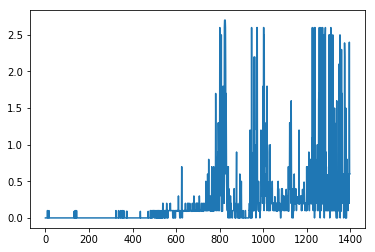

In [12]:
plt.plot(total_scores)

Text(0,0.5,'Score')

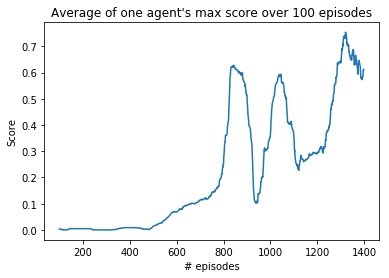

In [13]:
pd.Series(total_scores).rolling(100).mean().plot()
plt.title("Average of one agent's max score over 100 episodes")
plt.xlabel("# episodes")
plt.ylabel("Score")

#### Agent Testing

In [15]:
actor_current.load_state_dict(torch.load('a_current.pth'))
actor_network = actor_current

for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    
    for t in range(max_t):
        sts = torch.tensor(states, dtype=torch.float, device=device)

        actor_network.eval()
        with torch.no_grad():
            actions = actor_network(sts).detach().cpu().numpy()
        actor_network.train()
        
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: 0.7450000112876296
Total score (averaged over agents) this episode: 0.8450000127777457
Total score (averaged over agents) this episode: 0.1450000023469329
Total score (averaged over agents) this episode: 0.3450000053271651


When finished, you can close the environment.

In [ ]:
env.close()

### 4. Future work

1. A lot of experiments on 2-hidden-layer network didn't show a good result and 3-hidden-layer network required a proper selection on its architecture hyperparameters. This can show a potential improvement using a different NN architecture. For example, Sequence Model could be helpful to understand the game history and might improve or stabilise the agent training.

2. In DDPG algorithm, the actor network could be trained with Q-value estimate of critic-current or critic-target network. It seems like critic-target creates a slower but more smooth training, but this can be validated further to improve the training procedure.

3. It's unclear yet what triggers the collapse of the scores. Some Hypotheses are:
    - NN training failure. New experience completely wiped NN's knowledge
    - The game situation could be adverse against what NN specialised in
   The situation can be debugged in more detail, which will help pinpoint the potential pitfall of training and can help avoid such a collapse during training